From https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, regularizers
from tensorflow.keras import models
#import tensorflow_datasets as tfds

In [2]:
import ffmpeg
from pydub import AudioSegment

In [3]:
from data_set_params import DataSetParams
from scipy.io import wavfile
params = DataSetParams()

In [4]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'richfield_birds'#'dublin_dl_birds_split'#
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category]
categories

['Common Buzzard',
 'Common Kestrel',
 'Common Snipe',
 'Eurasian Curlew',
 'European Herring Gull',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan',
 'Tundra Swan (Bewicks)']

In [5]:
#AudioSegment.ffprobe  = "/usr/local/bin/ffmpeg"

In [6]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
#filenames = tf.io.gfile.glob('birds/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
filenames = tf.random.shuffle(filenames)

In [8]:
filenames

<tf.Tensor: shape=(1981,), dtype=string, numpy=
array([b'richfield_birds\\European Herring Gull\\xc677715_right.wav',
       b'richfield_birds\\European Robin\\xc681413.wav',
       b'richfield_birds\\Meadow Pipit\\xc546637_left.wav', ...,
       b'richfield_birds\\Common Kestrel\\xc445373_right.wav',
       b'richfield_birds\\Tundra Swan\\xc72959_right.wav',
       b'richfield_birds\\Eurasian Curlew\\xc667809.wav'], dtype=object)>

In [9]:
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(pathlib.Path(data_dir)/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1981
Number of examples per label: 166
Example file tensor: tf.Tensor(b'richfield_birds\\European Herring Gull\\xc677715_right.wav', shape=(), dtype=string)


In [10]:
TRAIN_SIZE = 0.8

cutoff = int(len(filenames) * TRAIN_SIZE)
train_files = filenames[:cutoff]
test_files  = filenames[cutoff:]

print('Training set size:', len(train_files))
print('Validation set size:', len(test_files))

Training set size: 1584
Validation set size: 397


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
audio, sr = tf.audio.decode_wav(tf.io.read_file(train_files[0].numpy()))
sr

<tf.Tensor: shape=(), dtype=int32, numpy=48000>

In [13]:
2**12

4096

In [14]:
def gen_complex_spec(waveform, params):
    nfft     = int(0.01*48000) #params.fft_win_length
    noverlap = int(0.25*nfft) #params.fft_overlap
    
    # window data
    #step    = nfft - noverlap
    step = 2**12
    waveform = tf.cast(waveform, tf.float32)
    
    # produces an array of complex numbers representing magnitude and phase
    complex_spec = tf.signal.stft(
        waveform, frame_length=nfft, frame_step=step)
    return complex_spec #complex_spec

In [15]:
def multi_spec_stack(complex_spec, choices = ['Mod']):
    #possible components:
    ##Mod    modulus/absolute value (regular)
    ##Re     real component
    ##AbsRe  abs(real component)
    ##Im     imaginary component
    ##AbsIm  abs(imaginary component)
    ##Ang    angular componant
    ##AbsAng abs(angular componant)
    spec_arr = []
    for c in choices:
        def apply_func(x,c):
            if c == 'Mod':
                return tf.math.abs(x)
            if c == 'Re':
                return tf.math.real(x)
            if c == 'AbsRe':
                return tf.math.abs(tf.math.real(x))
            if c == 'Im':
                return tf.math.imag(x)
            if c == 'AbsIm':
                return tf.math.abs(tf.math.imag(x))
            if c == 'Ang':
                return tf.math.ang(x)
            if c == 'AbsAng':
                return tf.math.abs(tf.math.imag(x))
        spec_arr.append(apply_func(complex_spec,c))
    return tf.stack(spec_arr,-1)

In [16]:
def multi_spec_post(spec):
    spec_shp         = tf.shape(spec)
    spec_cutoff      = [0, 1, 0]
    spec_cutoff_size = [spec_shp[0],spec_shp[1]-1, spec_shp[2]]
    spec             = tf.slice(spec, spec_cutoff, spec_cutoff_size)
    
    # only keep the relevant bands - could do this outside
    spec = spec[:, :100, :]
    
    spec_shp  = tf.shape(spec)
    req_width = 250
    
    if spec_shp[0] < req_width:
        zero_pad = tf.ones((req_width - spec_shp[0], spec_shp[1], spec_shp[2]))*1e-8
        spec     = tf.concat([spec, zero_pad], axis = 0)
    else:
        spec = tf.slice(spec, [0,0,0], [req_width, spec_shp[1], spec_shp[2]]) #spec[:,:req_width,:]
        
    #spec_shp   = tf.shape(spec) 
    #req_height = 512 
    #if spec_shp[1] < req_height:
    #    zero_pad = tf.zeros((spec_shp[0], req_height - spec_shp[1], spec_shp[2]))
    #    spec     = tf.stack((zero_pad, spec), axis = 1)
    #else:
    #    spec = tf.slice(spec, [0,0,0], [spec_shp[0], req_height, spec_shp[2]]) #spec[:req_height,:,:]

    
    spec = tf.transpose(spec, perm = [1,0,2])
    # perform log scaling - here the same as matplotlib
    #log_scaling = 2.0 * (1.0 / 44100) * (1.0/(np.abs(np.hanning(int(params.fft_win_length*44100)))**2).sum())
    #spec        = tf.math.log(1.0 + log_scaling*spec)
    
    #img = tf.io.decode_image(spec, dtype = tf.dtypes.float32)
    #spec.set_shape(tf.shape(spec))
    #spec = tf.compat.v1.image.resize(spec, [100, 50])
    #spec = spec.numpy.resize(100,50)
    #def spec_normalize(x, axis = (0,1), kd = True):
    #    return (x- x.min(axis=axis, keepdims=kd))/(x.max(axis=axis, keepdims=kd) - x.min(axis=axis, keepdims=kd))
    #spec = spec_normalize(spec)
    return spec

In [17]:
def decode_audio(audio_binary):
    audio, sr = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
    #return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis
    return audio[:,0], sr
def get_waveform_sr_and_label(file_path):
    label        = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform, _  = decode_audio(audio_binary)
    return waveform, label

In [18]:
def get_spectrogram_and_label_id(audio, label):
    #spectrogram = get_complex_spectrogram(audio)
    #print(dir(audio))
    complex_spec = gen_complex_spec(audio, params)
    multi_spec   = multi_spec_stack(complex_spec, choices)
    multi_spec   = multi_spec_post(multi_spec)
    #multi_spec = complex_spec
    label_id   = tf.argmax(label == categories)
    return multi_spec, label_id

In [19]:
def preprocess_dataset(files):
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_sr_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [20]:
def get_wf_dataset(files):
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_sr_and_label, num_parallel_calls=AUTOTUNE)
    return output_ds

In [21]:
choices = ['Mod']
train_ds = preprocess_dataset(train_files)
test_ds  = preprocess_dataset(test_files)

In [22]:
#tf.image.resize(train_ds, [100,50])

In [23]:
train_labs = [tf.argmax(get_label(y) == categories) for y in train_files]
test_labs  = [tf.argmax(get_label(y) == categories) for y in test_files]

In [24]:
train_labs_sort = train_labs
test_labs_sort  = test_labs
train_labs_sort.sort()
test_labs_sort.sort()

Text(0.5, 1.0, 'Test')

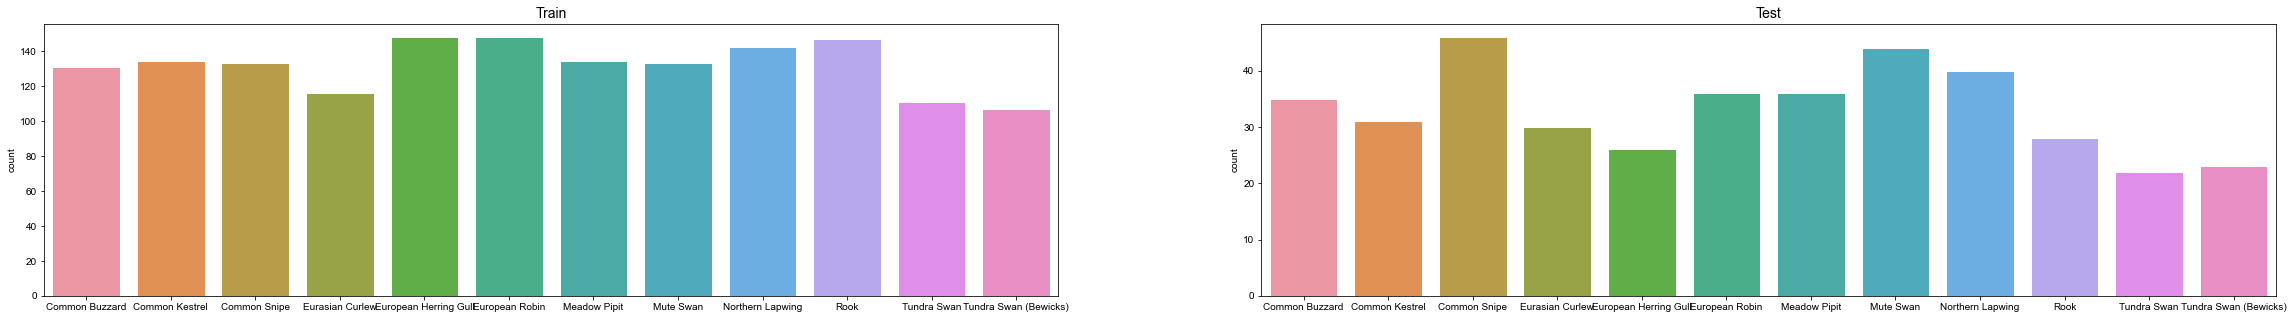

In [25]:
f, axes = plt.subplots(1, 2, figsize = (40,5))
l = []
for i in train_labs_sort:
    l.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = l, ax=axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize=8)
axes[0].set_title("Train", size = 14)

lt = []
for i in test_labs_sort:
    lt.append(categories[i])
sns.set_style('darkgrid')
sns.countplot(x = lt, ax=axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize=10)
axes[1].set_title("Test", size = 14)

In [26]:
batch_size = 32
train_ds   = train_ds.batch(batch_size)
test_ds    = test_ds.batch(batch_size)
train_ds   = train_ds.cache().prefetch(AUTOTUNE)
test_ds    = test_ds.cache().prefetch(AUTOTUNE)

In [27]:
for spec, lab in train_ds.unbatch().take(1):
    spec = spec
    input_shape = spec.shape
    print(categories[lab])

European Herring Gull


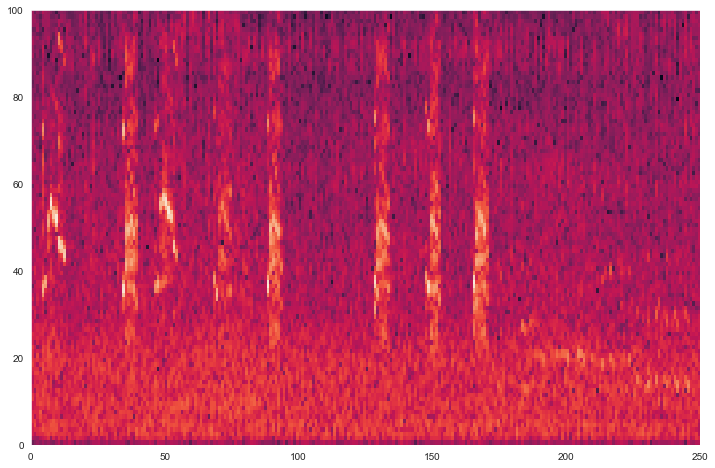

In [28]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.grid(False)
ax.pcolormesh(np.log(spec[:,:,0]+np.finfo(float).eps))

In [29]:
#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
num_labels = len(categories)

In [30]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    #preprocessing.Resizing(256, 64), 
    #norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 248, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 124, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 122, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 61, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 59, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 29, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9280)              0

In [31]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [33]:
EPOCHS = 2
history = model.fit(
    train_ds, 
    validation_data = test_ds,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/2
50/50 [==============================] - 40s 792ms/step - loss: 2.4313 - accuracy: 0.2210 - val_loss: 2.3128 - val_accuracy: 0.3048
Epoch 2/2
50/50 [==============================] - 11s 218ms/step - loss: 2.2812 - accuracy: 0.3043 - val_loss: 2.1880 - val_accuracy: 0.3325


In [35]:
np.load("y_true20220126_152914_richfield_shallow_net9Mod_.npy")

array([ 8,  2,  3,  3, 10,  3,  4, 10,  7,  4,  5,  2,  0, 11,  5, 10,  0,
        7,  1,  9, 11,  5,  5,  9,  4,  2,  6,  6, 10,  3,  8,  6,  4,  9,
        7,  0,  3,  7,  9,  6,  6,  9,  4,  8,  6,  6,  2,  0,  8,  6,  6,
        5,  5,  5,  4,  0,  6,  4, 10,  0,  0,  9,  5,  8,  7,  7,  3,  3,
        6,  2,  7,  2,  2, 10,  5,  0,  2,  4,  2,  0,  2,  3, 10,  3,  4,
       11, 10,  8, 10,  2,  0, 10,  5,  3, 10,  9,  9,  9, 10,  4,  3,  5,
        3, 10,  0,  3,  5,  9,  4,  0,  5,  9,  9,  6,  8,  8,  9,  4, 11,
        5,  1,  2,  2,  3, 11,  1, 10,  5,  8,  2,  1,  8, 11,  1,  6,  1,
        2,  0,  3,  8,  0,  5,  8, 10,  6,  5,  1,  1,  9,  2,  8,  3, 10,
        9, 11,  8,  6,  6, 10, 11, 10,  3,  9,  9,  9,  5, 10,  2,  0,  2,
        4,  6,  5,  7,  6, 11, 10, 10,  1, 11,  1,  7,  3,  2,  1, 11,  2,
        8,  6,  8,  7,  6,  2,  8,  5,  1,  6,  1,  4,  7,  4,  4,  4,  5,
        6,  8,  4,  2,  0,  0,  3,  5,  0,  2,  3,  1,  2,  1, 11,  0,  5,
        8,  1,  8,  8,  1

In [ ]:
from datetime import datetime

In [ ]:
#model.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net.h5')

In [ ]:
pd.DataFrame(metrics)

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
import plotly.graph_objs as go
metrics = history.history

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['loss'], 
                         mode = 'lines', name = 'Training',
                         line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_loss'], 
                         mode = 'lines', name = 'Validation',
                         line = dict(color='orange')))
fig.update_layout(title='Loss Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['accuracy'], 
                         mode = 'lines', name = 'Training',
                        line = dict(color='dodgerblue')))
fig.add_trace(go.Scatter(x = history.epoch, y = metrics['val_accuracy'], 
                         mode = 'lines', name = 'Validation',
                        line = dict(color='orange')))
fig.update_layout(title='Accuracy Curve',
                   xaxis_title='Epoch',
                   yaxis_title='Accuracy')

fig.show()

In [ ]:
#model = models.load('20211108_235747richfield_shallow_net')

In [169]:
#todo: confusion matrix and other 
y_pred = np.argmax(model.predict(test_ds), axis=-1)
y_true = [y for _,y in test_ds.unbatch()]

In [170]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[17,  0,  6,  0,  0,  0,  0,  1,  1,  0,  0,  0],
       [ 0, 29,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 4,  0, 34,  0,  0,  0,  0,  1,  2,  0,  1,  0],
       [ 1,  2,  7, 20,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  0, 28,  0,  0,  1,  0,  0,  1,  2],
       [ 0,  0,  6,  0,  0, 23,  2,  0,  0,  0,  0,  0],
       [ 0,  1,  4,  0,  0,  0, 25,  0,  0,  0,  1,  0],
       [ 1,  0, 11,  1,  0,  0,  0, 14,  0,  0,  3,  0],
       [ 1,  0, 10,  0,  2,  2,  0,  1, 17,  0,  0,  0],
       [ 0,  0,  6,  0,  1,  0,  0,  0,  0, 34,  0,  0],
       [ 2,  0,  7,  0,  0,  0,  0,  3,  0,  2, 16,  5],
       [ 0,  0,  5,  0,  1,  0,  0,  1,  1,  1,  5, 17]], dtype=int64)

In [171]:
import plotly.figure_factory as ff

z = cm

x = categories
y = categories
#y.reverse()

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion<br>matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                  yaxis=dict(autorange='reversed'),
                  title_x=0
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.26,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [172]:
fig.write_html('confusion_matrix'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net.html')

In [173]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_pred_proba = model.predict(test_ds)[::,1]
#fpr, tpr, _  = roc_curve(y_true,  y_pred_proba)

In [174]:
pred_lists = model.predict(test_ds)

In [175]:
pred_df = pd.DataFrame(pred_lists, columns = categories)

In [176]:
pred_df_softmax = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)

In [177]:
#pred_df_softmax.to_numpy()

In [178]:
from sklearn.preprocessing import OneHotEncoder
onehot_data = OneHotEncoder(sparse=False)
onehot_data = onehot_data.fit_transform(np.array(y_true).reshape(len(y_true),1))

In [179]:
#onehot_data
from itertools import cycle

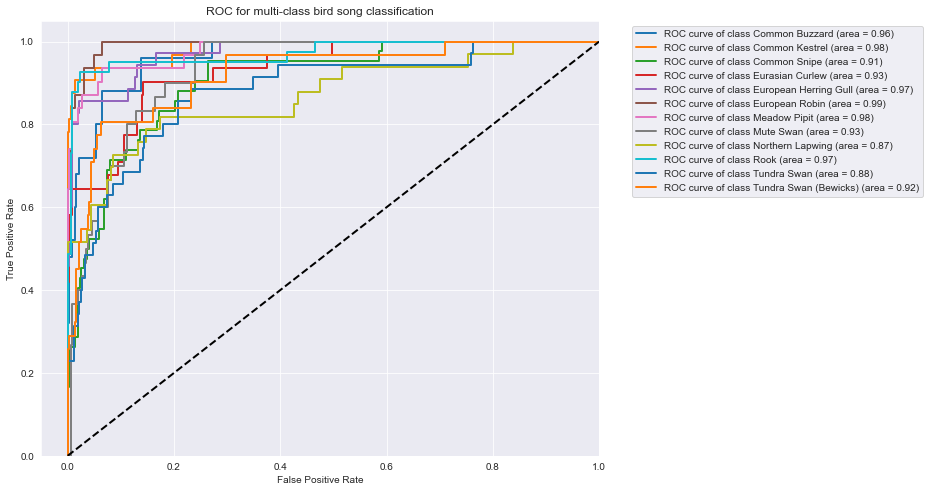

In [180]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(categories)
lw = 2
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(onehot_data[:, i], pred_df_softmax.to_numpy()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             #color=color, 
             lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class bird song classification')
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1))#, loc='upper right')
plt.show()

In [181]:
for i in range(n_classes):
    print('AUC of {0}: \t{1:0.2f}'.format(categories[i], roc_auc[i]))

AUC of Common Buzzard: 	0.96
AUC of Common Kestrel: 	0.98
AUC of Common Snipe: 	0.91
AUC of Eurasian Curlew: 	0.93
AUC of European Herring Gull: 	0.97
AUC of European Robin: 	0.99
AUC of Meadow Pipit: 	0.98
AUC of Mute Swan: 	0.93
AUC of Northern Lapwing: 	0.87
AUC of Rook: 	0.97
AUC of Tundra Swan: 	0.88
AUC of Tundra Swan (Bewicks): 	0.92


In [182]:
fig = go.Figure()
#colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i in range(n_classes):
    fig.add_trace(go.Scatter(x = fpr[i], y = tpr[i], 
                             mode = 'lines', 
                             name = 'ROC curve of {0} (area = {1:0.2f})'.format(categories[i], roc_auc[i])))
fig.update_layout(title       = 'ROC for multi-class bird song classification',
                  xaxis_title = 'False Positive Rate',
                  yaxis_title = 'True Positive Rate')

fig.show()

# Multi-channel work

In [183]:
choices = ['AbsRe', 'AbsIm', 'Mod', 'AbsAng']

In [184]:
train_ds_mult = preprocess_dataset(train_files)
test_ds_mult  = preprocess_dataset(test_files)

In [185]:
for spec, lab in train_ds_mult.take(1):
    input_shape_mult = spec.shape
    #print(lab)
    #print(lab)

In [186]:
batch_size    = 32
train_ds_mult = train_ds_mult.batch(batch_size)
test_ds_mult  = test_ds_mult.batch(batch_size)
train_ds_mult = train_ds_mult.cache().prefetch(AUTOTUNE)
test_ds_mult  = test_ds_mult.cache().prefetch(AUTOTUNE)

In [187]:
model_config = model.get_config()
tf_shape     = input_shape_mult
model_config["layers"][0]["config"]["batch_input_shape"] = (None, tf_shape[0], tf_shape[1], tf_shape[2])

In [188]:
model_mult = tf.keras.Sequential.from_config(model_config)
model_mult.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 998, 16)      592       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 499, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 497, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 248, 16)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 246, 32)       4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 123, 32)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 118080)           

In [189]:
#need to copy the weights from other model
#from https://towardsdatascience.com/implementing-transfer-learning-from-rgb-to-multi-channel-imagery-f87924679166
# Expand weights dimension to match new input channels
def multify_weights(kernel, out_channels):
    mean_1d = np.mean(kernel, axis=-2).reshape(kernel[:,:,-1:,:].shape)
    tiled   = np.tile(mean_1d, (out_channels, 1))
    return(tiled)


# Loop through layers of both original model 
# and custom model and copy over weights 
# layer_modify refers to first convolutional layer
def copy_weights_tl(model_orig, custom_model, layer_modify):
    layer_to_modify = [layer_modify]

    conf = custom_model.get_config()
    layer_names   = [conf['layers'][x]['config']['name'] for x in range(len(conf['layers']))]
    input_channel = conf["layers"][0]["config"]["batch_input_shape"][-1]
    #old_input_channel = model_orig.get_config()["layers"][0]["config"]["batch_input_shape"][-1]

    for layer in model_orig.layers:
        if layer.name in layer_names:
            if layer.get_weights() != []:
                target_layer = custom_model.get_layer(layer.name)

                if layer.name in layer_to_modify:    
                    kernels = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
            
                    kernels_extra_channel = multify_weights(kernels, input_channel)
                    #print('kernels_extra_channel', kernels_extra_channel.shape)                                
                    target_layer.set_weights([kernels_extra_channel, biases])
                    target_layer.trainable = False

                else:
                    target_layer.set_weights(layer.get_weights())
                    target_layer.trainable = False

In [190]:
copy_weights_tl(model, model_mult, model_config["layers"][1]['config']['name'])

In [191]:
#model_config["layers"][1]["config"]["groups"] = len(choices)

In [192]:
model_config["layers"]#[3]['config']['name']

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (None, 256, 1000, 4),
   'dtype': 'float32',
   'sparse': False,
   'ragged': False,
   'name': 'input_3'}},
 {'class_name': 'Conv2D',
  'config': {'name': 'conv2d_9',
   'trainable': True,
   'dtype': 'float32',
   'filters': 16,
   'kernel_size': (3, 3),
   'strides': (1, 1),
   'padding': 'valid',
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'groups': 1,
   'activation': 'relu',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'GlorotUniform',
    'config': {'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}},
 {'class_name': 'MaxPooling2D',
  'config': {'name': 'max_pooling2d_9',
   'trainable': True,
   'dtype': 'float32',
   'pool_size': (2, 2),
   'padding': 'valid',
   'strides': (2, 2),
   'data_format': 'c

In [193]:
model_mult.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [194]:
EPOCHS = 10
history_mult = model_mult.fit(
    train_ds_mult, 
    validation_data = test_ds_mult,  
    epochs          = EPOCHS,
    callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
50/50 [==============================] - 68s 1s/step - loss: 0.8950 - accuracy: 0.7633 - val_loss: 1.8201 - val_accuracy: 0.6801
Epoch 2/10
50/50 [==============================] - 35s 692ms/step - loss: 0.8753 - accuracy: 0.7771 - val_loss: 1.8201 - val_accuracy: 0.6801
Epoch 3/10
50/50 [==============================] - 35s 700ms/step - loss: 0.8833 - accuracy: 0.7645 - val_loss: 1.8201 - val_accuracy: 0.6801
Epoch 00003: early stopping


In [195]:
model_mult.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net'+'mult'+'.h5')

In [196]:
model_mult_fresh = tf.keras.Sequential.from_config(model_config)

In [197]:
model_mult_fresh.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [198]:
EPOCHS = 10
history_mult_fresh = model_mult_fresh.fit(
    train_ds_mult, 
    validation_data = test_ds_mult,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
50/50 [==============================] - 118s 2s/step - loss: 2.4413 - accuracy: 0.2273 - val_loss: 2.1074 - val_accuracy: 0.3854
Epoch 2/10
50/50 [==============================] - 117s 2s/step - loss: 2.0397 - accuracy: 0.3662 - val_loss: 1.8208 - val_accuracy: 0.4685
Epoch 3/10
50/50 [==============================] - 115s 2s/step - loss: 1.7880 - accuracy: 0.4621 - val_loss: 1.6662 - val_accuracy: 0.5315
Epoch 4/10
50/50 [==============================] - 116s 2s/step - loss: 1.6263 - accuracy: 0.5057 - val_loss: 1.5390 - val_accuracy: 0.5743
Epoch 5/10
50/50 [==============================] - 117s 2s/step - loss: 1.4435 - accuracy: 0.5764 - val_loss: 1.4338 - val_accuracy: 0.6297
Epoch 6/10
50/50 [==============================] - 113s 2s/step - loss: 1.3129 - accuracy: 0.6263 - val_loss: 1.3317 - val_accuracy: 0.6675
Epoch 7/10
50/50 [==============================] - 114s 2s/step - loss: 1.1675 - accuracy: 0.6528 - val_loss: 1.3016 - val_accuracy: 0.6725
Epoch 8/10
50

In [199]:
model_mult_fresh.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net'+'mult_fresh'+'.h5')

In [200]:
model_mult_sep = models.Sequential([
    layers.DepthwiseConv2D(
        depth_multiplier=1,
        kernel_size=(3, 3),
        input_shape=input_shape_mult),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_mult_sep.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 998, 16)      160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 499, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 497, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 248, 16)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 246, 32)       4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 123, 32)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 118080)           

In [201]:
model_mult_sep.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy',
)

In [202]:
EPOCHS = 10
history_mult_sep = model_mult_sep.fit(
    train_ds_mult, 
    validation_data = test_ds_mult,  
    epochs          = EPOCHS,
    #callbacks       = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
50/50 [==============================] - 143s 3s/step - loss: 2.4205 - accuracy: 0.2285 - val_loss: 2.0769 - val_accuracy: 0.3879
Epoch 2/10
50/50 [==============================] - 141s 3s/step - loss: 2.0766 - accuracy: 0.3643 - val_loss: 1.8296 - val_accuracy: 0.4685
Epoch 3/10
50/50 [==============================] - 138s 3s/step - loss: 1.8585 - accuracy: 0.4205 - val_loss: 1.6579 - val_accuracy: 0.5088
Epoch 4/10
50/50 [==============================] - 138s 3s/step - loss: 1.6602 - accuracy: 0.4943 - val_loss: 1.5469 - val_accuracy: 0.5315
Epoch 5/10
50/50 [==============================] - 136s 3s/step - loss: 1.5397 - accuracy: 0.5290 - val_loss: 1.4961 - val_accuracy: 0.5567
Epoch 6/10
50/50 [==============================] - 138s 3s/step - loss: 1.4016 - accuracy: 0.5701 - val_loss: 1.3780 - val_accuracy: 0.5894
Epoch 7/10
50/50 [==============================] - 140s 3s/step - loss: 1.2860 - accuracy: 0.5985 - val_loss: 1.3364 - val_accuracy: 0.6322
Epoch 8/10
50

In [203]:
model_mult_sep.save('models/'+datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'richfield_shallow_net'+'mult_sep'+'.h5')

## Outline of script needed:
for i in 1,...,20 iterations
-  shuffles files
-  seperates into train/test
-  For different combinations of Mod (default), AbsRe, AbsIm, AbsArg
    -  create spectrogram features (X) and labels (y)
    -  create training and test tensorflow datasets and batch
    -  train from scratch for 5,10,25,50 epochs
    -  record history(loss, accuracy), yTrue and yPred,  
    -  save confusion matrices
-  Also try 
    - work on making the convolution kernel different for each channel, and for the output to be the mean 
    - freeze layers (all but first or last) to fine tune training
    - Transfer learning from BirdNet
